<a href="https://colab.research.google.com/github/gusmendesbh/Crowdfunding_ETL/blob/main/car_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import cufflinks as cf
import plotly
import plotly.express as px


In [3]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 114 kB in 2s (69.3 kB/s)
Reading package lists... Done


In [4]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [5]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
sales_url = "https://car-sales-data-group2.s3.amazonaws.com/car_sales_data.csv"
spark.sparkContext.addFile(sales_url)
car_sales_df = spark.read.csv(SparkFiles.get("car_sales_data.csv"), sep=",", header=True)

# Show the sales data.
car_sales_df.show()

+----------+------------------+-----------------+---------+---------+--------+----------+--------------------+-----------------+
|      Date|       Salesperson|    Customer Name| Car Make|Car Model|Car Year|Sale Price|     Commission Rate|Commission Earned|
+----------+------------------+-----------------+---------+---------+--------+----------+--------------------+-----------------+
|2022-08-01|   Monica Moore MD|      Mary Butler|   Nissan|   Altima|    2018|     15983| 0.07049522770435404|          1126.73|
|2023-03-15|      Roberto Rose|   Richard Pierce|   Nissan|    F-150|    2016|     38474| 0.13443883688865882|           5172.4|
|2023-04-29|      Ashley Ramos|     Sandra Moore|     Ford|    Civic|    2016|     33340| 0.11453592158660743|          3818.63|
|2022-09-04|    Patrick Harris|     Johnny Scott|     Ford|   Altima|    2013|     41937| 0.09219072181202051|           3866.2|
|2022-06-16|        Eric Lopez|    Vanessa Jones|    Honda|Silverado|    2022|     20256| 0.11348

In [6]:
car_sales_pandas = car_sales_df.toPandas()

In [7]:
car_sales_pandas.isnull().sum()

Date                 0
Salesperson          0
Customer Name        0
Car Make             0
Car Model            0
Car Year             0
Sale Price           0
Commission Rate      0
Commission Earned    0
dtype: int64

In [8]:
car_sales_pandas.describe()

,Date,Salesperson,Customer Name,Car Make,Car Model,Car Year,Sale Price,Commission Rate,Commission Earned
count,2500000,2500000,2500000,2500000,2500000,2500000,2500000,2500000,2500000
unique,366,518657,518251,5,5,13,40001,2500000,586911
top,2022-12-24,Michael Smith,Michael Smith,Honda,Silverado,2013,14817,0.07049522770435404,2218.59
freq,7144,1229,1167,500687,500842,192970,101,1,22


In [9]:
car_sales_pandas['Car Make'].value_counts()

Honda        500687
Chevrolet    500455
Toyota       500147
Ford         499781
Nissan       498930
Name: Car Make, dtype: int64

In [10]:
car_sales_pandas.Salesperson.value_counts()

Michael Smith         1229
Michael Johnson        976
David Smith            821
James Smith            796
Jennifer Smith         753
                      ... 
Mr. John Prince          1
Joseph Roberts MD        1
Matthew Bright DVM       1
Mario Cohen              1
Mr. Calvin Hardin        1
Name: Salesperson, Length: 518657, dtype: int64

In [11]:
car_sales_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Date               object
 1   Salesperson        object
 2   Customer Name      object
 3   Car Make           object
 4   Car Model          object
 5   Car Year           object
 6   Sale Price         object
 7   Commission Rate    object
 8   Commission Earned  object
dtypes: object(9)
memory usage: 171.7+ MB


In [12]:
import datetime
car_sales_pandas['Date'] = pd.to_datetime(car_sales_pandas['Date'])
car_sales_pandas['Sale Price'] = car_sales_pandas['Sale Price'].astype(float)
car_sales_pandas['Commission Rate'] = car_sales_pandas['Commission Rate'].astype(float)
car_sales_pandas['Commission Earned'] = car_sales_pandas['Commission Earned'].astype(float)

In [13]:
car_sales_pandas.loc[car_sales_pandas['Car Model'] == 'Silverado', 'Car Make'] = 'Chevrolet'
car_sales_pandas.loc[car_sales_pandas['Car Model'] == 'Corolla', 'Car Make'] = 'Toyota'
car_sales_pandas.loc[car_sales_pandas['Car Model'] == 'Civic', 'Car Make'] = 'Honda'
car_sales_pandas.loc[car_sales_pandas['Car Model'] == 'Altima', 'Car Make'] = 'Nissan'
car_sales_pandas.loc[car_sales_pandas['Car Model'] == 'F-150', 'Car Make'] = 'Ford'

In [14]:
car_sales_pandas = car_sales_pandas.sort_values(by=['Date']).reset_index(drop=True)


In [15]:
car_sales_pandas.head()

,Date,Salesperson,Customer Name,Car Make,Car Model,Car Year,Sale Price,Commission Rate,Commission Earned
0,2022-05-01,Sherri Collins,Laura Pena DDS,Ford,F-150,2010,34903.0,0.092778,3238.24
1,2022-05-01,Antonio Brown,Rhonda Boyd,Toyota,Corolla,2019,25369.0,0.114699,2909.81
2,2022-05-01,Laura Delgado,Jennifer Garcia,Honda,Civic,2010,28079.0,0.123890,3478.70
3,2022-05-01,Jessica Banks,Brian Gonzalez,Honda,Civic,2010,34979.0,0.087169,3049.07
4,2022-05-01,Thomas Bailey,Stephen Mitchell,Toyota,Corolla,2021,44299.0,0.062876,2785.32


In [16]:
counts = car_sales_pandas.Salesperson.value_counts()
top_5 = counts[5:].index
names_list = top_5.tolist()
salesperson_df = car_sales_pandas[car_sales_pandas['Salesperson'].isin(['Michael Smith','Michael Johnson','David Smith','James Smith', 'Jennifer Smith'])]
salesperson_df

,Date,Salesperson,Customer Name,Car Make,Car Model,Car Year,Sale Price,Commission Rate,Commission Earned
917,2022-05-01,David Smith,Stephanie Fields,Ford,F-150,2011,23247.0,0.102908,2392.30
1133,2022-05-01,David Smith,Leonard Chandler,Nissan,Altima,2017,25946.0,0.133187,3455.66
1513,2022-05-01,Jennifer Smith,Catherine Barnett,Nissan,Altima,2016,23845.0,0.120236,2867.03
1734,2022-05-01,Michael Johnson,Brandon Lee,Honda,Civic,2015,10029.0,0.128332,1287.05
1855,2022-05-01,James Smith,Edward Cochran,Honda,Civic,2021,47159.0,0.057490,2711.18
...,...,...,...,...,...,...,...,...,...
2497507,2023-05-01,Michael Johnson,Angela Parker,Toyota,Corolla,2012,20309.0,0.100891,2049.00
2497759,2023-05-01,David Smith,Rhonda Moore,Ford,F-150,2011,10403.0,0.080956,842.19
2497959,2023-05-01,James Smith,Eric Frederick,Nissan,Altima,2017,23964.0,0.079450,1903.94
2497986,2023-05-01,Jennifer Smith,Shirley Wright,Toyota,Corolla,2021,44958.0,0.121929,5481.67


In [17]:
salesperson_df.Salesperson.value_counts()

Michael Smith      1229
Michael Johnson     976
David Smith         821
James Smith         796
Jennifer Smith      753
Name: Salesperson, dtype: int64

Car Model
Silverado    Axes(0.125,0.11;0.775x0.77)
Name: Commission Earned, dtype: object

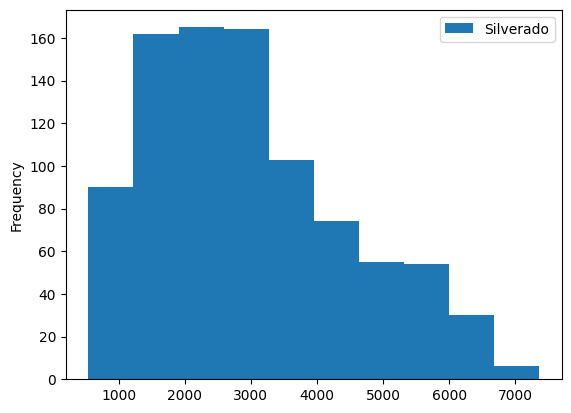

In [18]:
data_chevrolet = salesperson_df[salesperson_df["Car Make"]=='Chevrolet']
data_chevrolet.groupby("Car Model")["Commission Earned"].plot(kind='hist',legend=True)
                                                           

In [19]:
fig = px.line(data_chevrolet, x='Date', y='Sale Price', title='Cars Sale Price 2022-2023')
fig.show()

<ipython-input-20-9c2f4d742e6d>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

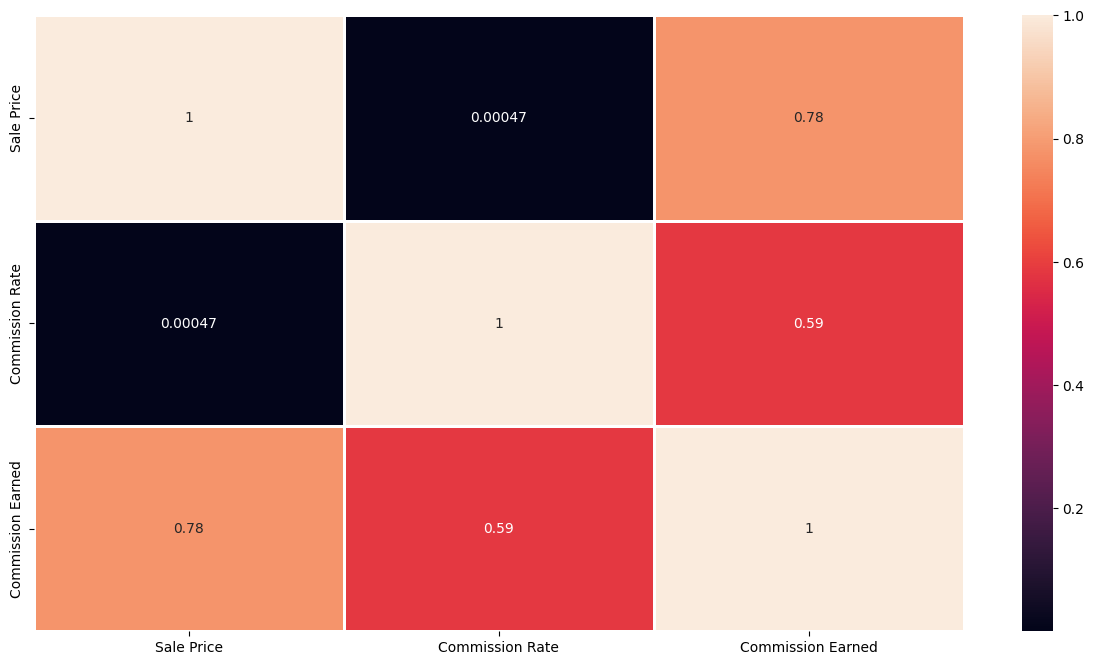

In [20]:
# Heatmap to show the correlation of the data
ax= plt.figure(figsize=(15,8))
sb.heatmap(car_sales_pandas.corr(),linewidths=1,linecolor='white',annot=True)

# Gus

In [21]:
car_sales_pandas.describe()

,Sale Price,Commission Rate,Commission Earned
count,2.500000e+06,2.500000e+06,2.500000e+06
mean,3.001218e+04,9.998766e-02,3.001005e+03
std,1.154514e+04,2.887202e-02,1.481467e+03
min,1.000000e+04,5.000014e-02,5.013400e+02
25%,2.001900e+04,7.496450e-02,1.821710e+03
50%,3.000600e+04,1.000058e-01,2.741910e+03
75%,4.002200e+04,1.250065e-01,3.978142e+03
max,5.000000e+04,1.500000e-01,7.494530e+03


In [22]:
# Drop the non-beneficial columns.
car_sales_pandas = car_sales_pandas.drop(['Salesperson','Customer Name','Car Make','Date'], axis=1)
car_sales_pandas.head()

,Car Model,Car Year,Sale Price,Commission Rate,Commission Earned
0,F-150,2010,34903.0,0.092778,3238.24
1,Corolla,2019,25369.0,0.114699,2909.81
2,Civic,2010,28079.0,0.123890,3478.70
3,Civic,2010,34979.0,0.087169,3049.07
4,Corolla,2021,44299.0,0.062876,2785.32


In [23]:
# Convert categorical data to numeric with `pd.get_dummies`
numeric_dummies = pd.get_dummies(car_sales_pandas)

In [24]:
# Supervised Learning
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
y = car_sales_pandas['Car Model']
X = car_sales_pandas.drop(columns=['Car Model'])


In [25]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [26]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
model = LogisticRegression(random_state=1)

# Fit the model using training data
model.fit(X_train, y_train)

LogisticRegression(random_state=1)

# Kevin

In [27]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt

# Creating function to produce boxplots
def boxplot(column_name):
  values = car_sales_pandas[column_name].tolist()
  fig1, ax1 = plt.subplots()
  ax1.set_title(column_name + ' Boxplot')
  ax1.set_ylabel(column_name)
  ax1.boxplot(values)
  plt.show()

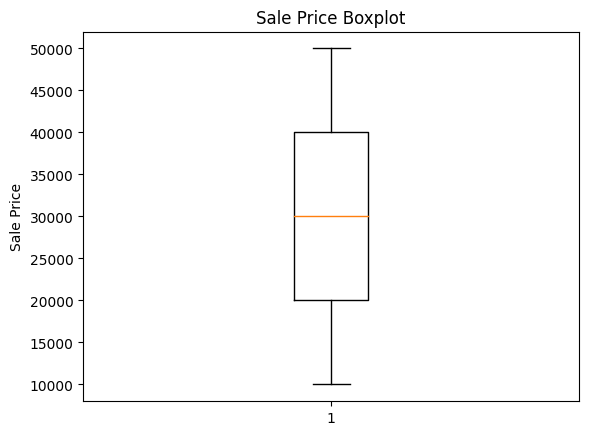

In [28]:
# Sale Price boxplot
boxplot('Sale Price')

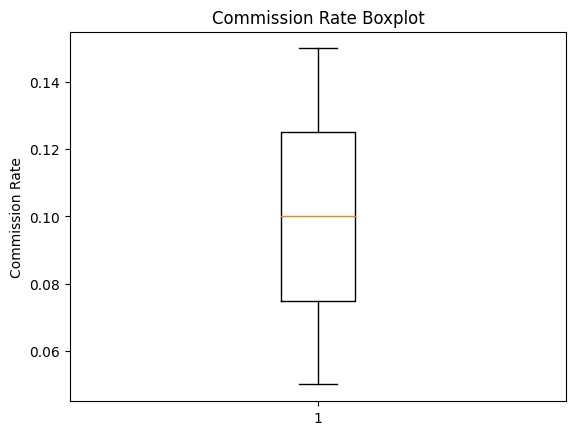

In [29]:
# Commission Rate boxplot
boxplot('Commission Rate')

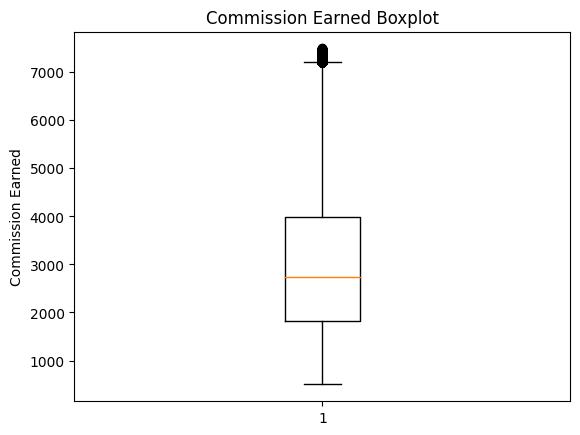

In [30]:
# Commission Earned boxplot
boxplot('Commission Earned')

In [31]:
# Collecting Outliers for Commission Earned
com_earned_values = car_sales_pandas['Commission Earned'].tolist()
quartiles = np.quantile(com_earned_values,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

potential_outliers = [commission for commission in com_earned_values if commission < lower_bound or commission > upper_bound]
print(len(potential_outliers))

3432


In [32]:
# Removing outliers for Commision Earned
car_sales_outliers_removed = car_sales_pandas[(car_sales_pandas['Commission Earned'] >= lower_bound) & (car_sales_pandas['Commission Earned'] <= upper_bound)]

# Fahmida

# Mohanathas

# TODO

-LOGISTIC REGRESSION - List of cars | try and predict sales for each car in the list - either if the car will sell or not above a certain price - Needs to add a column converting the sale price above or below 

-LINEAR REGRESSION - Predict number of sales for various sales persons for next year